# Continuous Data

In [ ]:
%matplotlib inline
import warnings
from IPython.display import display

warnings.filterwarnings("ignore")
# tag: remove-cell applied

## Quickstart

To run a continuous dataset:

In [ ]:
import pybmds

# create a continuous dataset
dataset = pybmds.ContinuousDataset(
    doses=[0, 25, 50, 75, 100],
    ns=[20, 20, 20, 20, 20],
    means=[6, 8, 13, 25, 30],
    stdevs=[4, 4.3, 3.8, 4.4, 3.7],
)

# create a session
session = pybmds.Session(dataset=dataset)
session.add_default_models()

# execute the session; recommend best-fitting model
session.execute_and_recommend()

# save excel report
df = session.to_df()
df.to_excel("output/report.xlsx")

# save to a word report
report = session.to_docx()
report.save("output/report.docx")

## Continuous datasets

Continuous datasets can defined using group level summary data or individual response data.

A continuous summary dataset requires a list of doses, mean responses, standard deviations, and the total number of subjects. All lists must be the same size, and there should be one item in each list for each dose-group. 

You can also add optional attributes, such as `name`, `dose_name`, `dose_units`, `response_name`, `response_units`, etc.

For example:

In [ ]:
dataset = pybmds.ContinuousDataset(
    name="Body Weight from ChemX Exposure",
    dose_name="Concentration",
    dose_units="ppm",
    response_units="kg",
    doses=[0, 25, 50, 75, 100],
    ns=[20, 20, 20, 20, 20],
    means=[6, 8, 13, 25, 30],
    stdevs=[4, 4.3, 3.8, 4.4, 3.7],
)
dataset.plot(figsize=(6,4))

A continuous individual dataset requires the dose and response for each individual. Both lists must be the same size. Additional options can also be added such as the name or units:

In [ ]:
dataset2 = pybmds.ContinuousIndividualDataset(
    name="Effect Y from ChemX Exposure",
    dose_name="Dose",
    dose_units="mg/kg/d",
    response_units="g",    
    doses=[
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 
        ],
    responses=[
        8.57, 8.71, 7.99, 9.27, 9.47, 10.06, 8.65, 9.13, 9.01, 8.35, 
        8.66, 8.45, 9.26, 8.76, 7.85, 9.01, 9.09, 9.57, 10.14, 10.49, 
        9.87, 10.26, 9.76, 10.24, 10.54, 10.72, 8.83, 10.02, 9.18, 10.87, 
        11.56, 10.59, 11.99, 11.59, 10.59, 10.52, 11.32, 12.0, 12.12, 12.64,
        10.96, 12.13, 12.77, 13.06, 13.16, 14.04, 14.01, 13.9, 12.99, 13.13,
    ],
)
dataset2.plot(figsize=(6,4))

## Single model fit

You can fit a specific model to the dataset and plot/print the results. The printed results will include the BMD, BMDL, BMDU, p-value, AIC, etc. 

For example, to fit the Hill model, run the following code and plot the results:

In [ ]:
from pybmds.models import continuous

model = continuous.Hill(dataset)
model.execute()
model.plot()

To view an output report:

In [ ]:
print(model.text())

You can change the range and initial value for any parameter in the model by following the same steps above.

### Change input settings

The default settings when running a continuous analysis are a BMR of 1 standard deviation from the BMD, a 95% confidence interval, and a normally distributed and constant variance between dose groups. 

If you fit a single model to your dataset, you can change these settings:

In [ ]:
model = continuous.Hill(dataset)
print(model.settings.tbl())
print(model.priors_tbl())

You can change individual model settings:


In [ ]:
model = continuous.Hill(
    dataset,
    settings={
        "bmr": 0.1,
        "bmr_type": pybmds.ContinuousRiskType.RelativeDeviation,
        "disttype": pybmds.ContinuousDistType.normal_ncv,
    },
)
model.settings.priors.update("k", max_value=3)
print(model.settings.tbl())
print(model.priors_tbl())

For the Polynomial model, degrees can be increased to a maximum of the lesser of `n`-1 or 8, where `n` is the number of dose groups.

In [ ]:
continuous.Polynomial(dataset, settings={"degree": 2})
continuous.Polynomial(dataset, settings={"degree": 3})

### Change parameter settings

To see a preview of the initial parameter settings:

In [ ]:
model = continuous.Hill(dataset)
print(model.settings.tbl())
print(model.priors_tbl())

You can also change the initial parameter settings shown above for any run of a single continuous model. Continuing with the Hill model example, you can set the power parameter `n` to be equal to 1. You do this by changing the initial, minimum, and maximum values of that parameter:

In [ ]:
model = continuous.Hill(dataset)
model.settings.priors.update("n", initial_value=1, min_value=1, max_value=1)
print(model.priors_tbl())

## Multiple model fit (sessions) and model recommendation

To run all the default models, save the results, and save the plot of the fit of the recommended model with the data:

In [ ]:
# create a continuous dataset
dataset = pybmds.ContinuousDataset(
    doses=[0, 25, 50, 75, 100],
    ns=[20, 20, 20, 20, 20],
    means=[6, 8, 13, 25, 30],
    stdevs=[4, 4.3, 3.8, 4.4, 3.7],
)

session = pybmds.Session(dataset=dataset)
session.add_default_models()

# execute the session
session.execute()

# recommend a best-fitting model
session.recommend()

# print recommended model and plot recommended model with dataset
model_index = session.recommender.results.recommended_model_index
if model_index:
    model = session.models[model_index]
    model.plot()

You can also plot all models:

In [ ]:
session.plot()

In [ ]:
session.plot(colorize=False)

To print a summary table of modeling results, create a custom function:

In [ ]:
import pandas as pd

def summary_table(session):
    data = []
    for model in session.models:
        data.append([
            model.name(), 
            model.results.bmdl, 
            model.results.bmd, 
            model.results.bmdu,             
            model.results.tests.p_values[1],
            model.results.tests.p_values[2],
            model.results.tests.p_values[3], 
            model.results.fit.aic
        ])
    
    df = pd.DataFrame(
        data=data, 
        columns=["Model", "BMDL", "BMD", "BMDU", "P-Value 2", "P-Value 3", "P-Value 4", "AIC"]
    )
    return df

summary_table(session)

### Change model settings

To change model settings to all default models added to a session:

In [ ]:
session = pybmds.Session(dataset=dataset)
session.add_default_models(
    settings={
        "disttype": pybmds.ContinuousDistType.normal_ncv,
        "bmr_type": pybmds.ContinuousRiskType.AbsoluteDeviation,
        "bmr": 2,
        "alpha": 0.1,
    }
)

Here, we changed the settings to assume normally distributed and non-constant variance between dose groups and a 90% confidence interval. We also changed the BMR type to be absolute deviation with a value of 2. You can use the default BMR for the given BMR type or specify a different value. You can also change the`disttype` to be `DistType.log_normal`. If a log-normal distribution is selected, only the Hill and Exponential models will be run.

### Run subset of models and select best fit

You can select a set of models and find the best fit, rather than using all of the default continuous models. 

For example, to model average on the Hill, Linear, and Exponential 3:

In [ ]:
session = pybmds.Session(dataset=dataset)
session.add_model(pybmds.Models.Linear)
session.add_model(pybmds.Models.ExponentialM3)
session.add_model(pybmds.Models.Hill)

session.execute()

### Model recommendation and selection

The `pybmds` package may recommend a best-fitting model based on a decision tree, but expert judgment may be required for model selection. To run model recommendation and view a recommended model, if one is recommended:

In [ ]:
session.recommend()

if session.recommended_model is not None:
    display(session.recommended_model.plot())
    print(session.recommended_model.text())

You can select a best-fitting model and output reports generated will indicate this selection.  This is a manual action. The example below selects the recommended model, but any model in the session could be selected.

In [ ]:
session.select(model=session.recommended_model, notes="Lowest AIC; recommended model")

## Jonckheere-Terpstra Trend Test

### Individual Response Data

To run the Jonckheere-Terpstra trend test on a single dataset with a strong apparent trend, first load an individual response continuous dataset:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pybmds
from pybmds.datasets.continuous import ContinuousIndividualDataset

dataset1 = ContinuousIndividualDataset(
    name="Effect Y from ChemX Exposure",
    dose_name="Dose",
    dose_units="mg/kg-day",
    response_units="g",
    doses=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 
        ], 
    responses=[
        8.57, 8.71, 7.99, 9.27, 9.47, 10.06, 8.65, 9.13, 9.01, 8.35, 
        8.66, 8.45, 9.26, 8.76, 7.85, 9.01, 9.09, 9.57, 10.14, 10.49, 
        9.87, 10.26, 9.76, 10.24, 10.54, 10.72, 8.83, 10.02, 9.18, 10.87, 
        11.56, 10.59, 11.99, 11.59, 10.59, 10.52, 11.32, 12.0, 12.12, 12.64,
        10.96, 12.13, 12.77, 13.06, 13.16, 14.04, 14.01, 13.9, 12.99, 13.13,
    ],
)

dataset1.plot(figsize=(6,4))

In [ ]:
# Run the Jonckheere-Terpstra trend test for an increasing trend
result1 = dataset1.trend(hypothesis="increasing")

# Display the results
print("Jonckheere-Terpstra Trend Test Result:")
print(f"Statistic: {result1.statistic:.4f}")
print(f"P-value: {result1.p_value:.4g}")
print(f"Hypothesis: {result1.hypothesis}")

# Run the two-sided test
result1_two_sided = dataset1.trend(hypothesis="two-sided")
print("\nTwo-sided test result:")
print(f"Statistic: {result1_two_sided.statistic:.4f}")
print(f"P-value: {result1_two_sided.p_value:.4g}")
print(f"Hypothesis: {result1_two_sided.hypothesis}")


Jonckheere-Terpstra Trend Test Result:
Statistic: 914.0000
P-value: 7.069e-13
Hypothesis: increasing

Two-sided test result:
Statistic: 914.0000
P-value: 1.414e-12
Hypothesis: two-sided


Alternatively, you can load an individual continuous response dataset from a CSV file and run the Jonckheere test on that data.

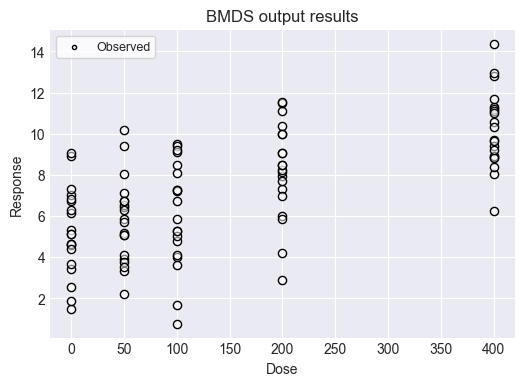

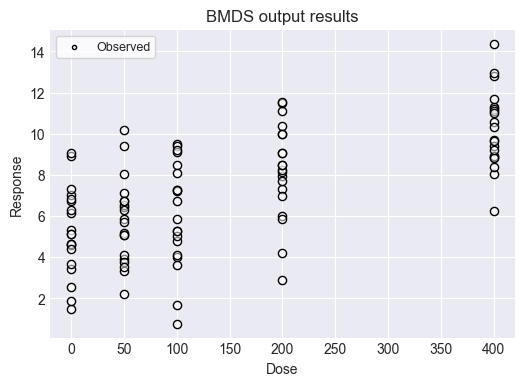

In [ ]:
# Load the CSV file (make sure JT_strong_trend.csv is in the same directory)
df = pd.read_csv('data/JT_strong_trend.csv')

dataset2 = ContinuousIndividualDataset(
    doses=df['doses'].values,
    responses=df['responses'].values,
)

dataset2.plot(figsize=(6,4))


In [ ]:
# Run the Jonckheere-Terpstra trend test for an increasing trend
result2 = dataset2.trend(hypothesis="increasing")

# Display the results
print("Jonckheere-Terpstra Trend Test Result:")
print(f"Statistic: {result2.statistic:.4f}")
print(f"P-value: {result2.p_value:.4g}")
print(f"Hypothesis: {result2.hypothesis}")

# Run the two-sided test
result2_two_sided = dataset2.trend(hypothesis="two-sided")
print("\nTwo-sided test result:")
print(f"Statistic: {result2_two_sided.statistic:.4f}")
print(f"P-value: {result2_two_sided.p_value:.4g}")
print(f"Hypothesis: {result2_two_sided.hypothesis}")

Jonckheere-Terpstra Trend Test Result:
Statistic: 3065.0000
P-value: 4.544e-11
Hypothesis: increasing

Two-sided test result:
Statistic: 3065.0000
P-value: 9.089e-11
Hypothesis: two-sided


As a further example, the Jonckheere test can be run on a dataset with no apparent trend:   

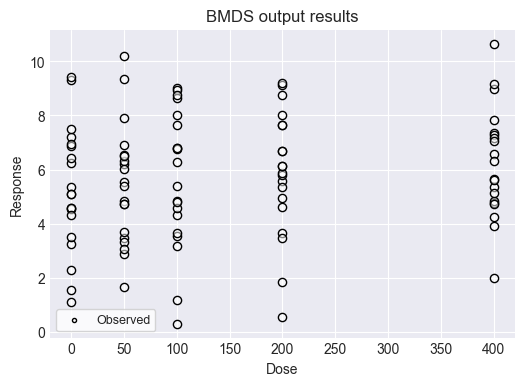

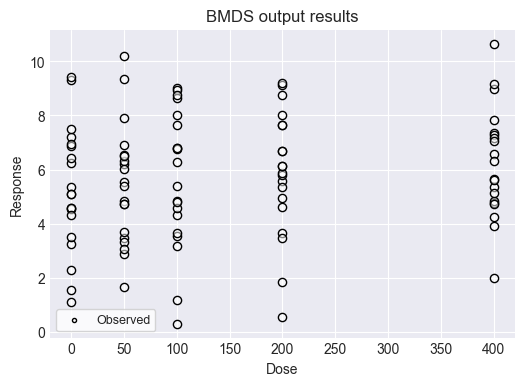

In [ ]:
# Load the CSV file (make sure JT_no_trend.csv is in the same directory)
df2 = pd.read_csv('data/JT_no_trend.csv')

dataset3 = ContinuousIndividualDataset(
    doses=df2['doses'].values,
    responses=df2['responses'].values,
)

dataset3.plot(figsize=(6,4))

In [ ]:
# Run the Jonckheere-Terpstra trend test for an increasing trend
result3 = dataset3.trend(hypothesis="increasing")

# Display the results
print("Jonckheere-Terpstra Trend Test Result:")
print(f"Statistic: {result3.statistic:.4f}")
print(f"P-value: {result3.p_value:.4g}")
print(f"Hypothesis: {result3.hypothesis}")

# Run the two-sided test
result3_two_sided = dataset3.trend(hypothesis="two-sided")
print("\nTwo-sided test result:")
print(f"Statistic: {result3_two_sided.statistic:.4f}")
print(f"P-value: {result3_two_sided.p_value:.4g}")
print(f"Hypothesis: {result3_two_sided.hypothesis}")

Jonckheere-Terpstra Trend Test Result:
Statistic: 2250.0000
P-value: 0.06407
Hypothesis: increasing

Two-sided test result:
Statistic: 2250.0000
P-value: 0.1281
Hypothesis: two-sided


### Summary Response Data

Often, only summary continuous data (reported as means and standard deviations) is available to risk assessors.  The Jockheere-Terpstra trend test can stil be applied to such data after synthetic individual response data is generated.  First, load and plot a summary dataset:

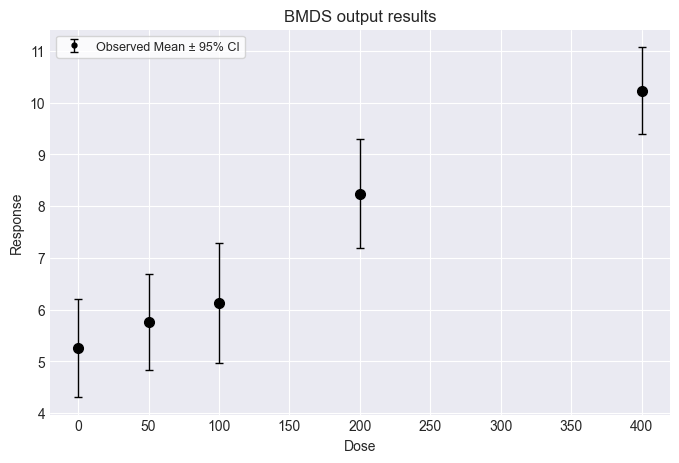

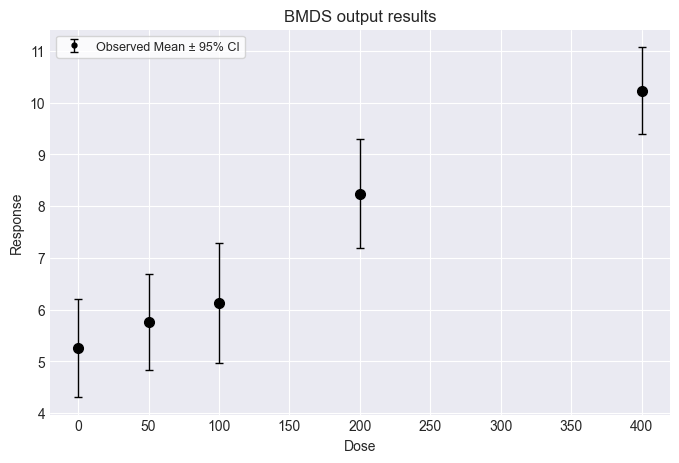

In [ ]:
from pybmds.datasets.continuous import ContinuousDataset

dataset4 = pybmds.ContinuousDataset(
    doses=[0, 50, 100, 200, 400],
    ns=[20, 20, 20, 20, 20],
    means=[5.26, 5.76, 6.13, 8.24, 10.23],
    stdevs=[2.03, 1.97, 2.47, 2.24, 1.8],
)
dataset4.plot()


To run the Jonckheere-Terpstra trend test on the summary data, first, "synthetic" individual responses must be generated.  These synthetic data are generated such that the summary statistics (i.e., means, standard deviations) calculated from them will match the user-provided summary statistics.  

Call the `summary.trend()` function to generate the synthetic individual responses and run the Jonckheere-Terpstra trend test.  Optional inputs for the generation of the synthetic individual responses include `seed` (random number than can be entered to facilitate reproducibility of results), the option to `impose positivity` of individual responses (useful for endpoints were negative values are not possible), a `tolerance` value (to check how close the generated summary statistics match the entered values), and `max iterations` (the maximum number of iterations the function will use to try and match synthetic summary statistics to entered values).

In [ ]:
# Run the Jonckheere-Terpstra trend test for an increasing trend
result4 = dataset4.summary_trend(hypothesis="increasing")

# Display the results
print("Jonckheere-Terpstra Trend Test Result:")
print(f"Statistic: {result4.statistic:.4f}")
print(f"P-value: {result4.p_value:.4g}")
print(f"Hypothesis: {result4.hypothesis}")

# Run the two-sided test
result4_two_sided = dataset4.summary_trend(hypothesis="two-sided")
print("\nTwo-sided test result:")
print(f"Statistic: {result4_two_sided.statistic:.4f}")
print(f"P-value: {result4_two_sided.p_value:.4g}")
print(f"Hypothesis: {result4_two_sided.hypothesis}")

Jonckheere-Terpstra Trend Test Result:
Statistic: 3078.0000
P-value: 2.681e-11
Hypothesis: increasing

Two-sided test result:
Statistic: 3078.0000
P-value: 5.363e-11
Hypothesis: two-sided


To run the Jonckheere-Terpstra trend test on summary data with no trend:

In [ ]:
dataset5 = pybmds.ContinuousDataset(
    doses=[0, 50, 100, 200, 400],
    ns=[20, 20, 20, 20, 20],
    means=[5.26, 5.30, 5.28, 5.27, 5.29],
    stdevs=[2.03, 1.97, 2.47, 2.24, 1.8],
)

# Run the Jonckheere-Terpstra trend test for an increasing trend
result5 = dataset5.summary_trend(hypothesis="increasing")

# Display the results
print("Jonckheere-Terpstra Trend Test Result:")
print(f"Statistic: {result5.statistic:.4f}")
print(f"P-value: {result5.p_value:.4g}")
print(f"Hypothesis: {result5.hypothesis}")

# Run the two-sided test
result5_two_sided = dataset5.summary_trend(hypothesis="two-sided")
print("\nTwo-sided test result:")
print(f"Statistic: {result5_two_sided.statistic:.4f}")
print(f"P-value: {result5_two_sided.p_value:.4g}")
print(f"Hypothesis: {result5_two_sided.hypothesis}")

Jonckheere-Terpstra Trend Test Result:
Statistic: 2000.0000
P-value: 0.5
Hypothesis: increasing

Two-sided test result:
Statistic: 2000.0000
P-value: 1
Hypothesis: two-sided
